In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.gridspec import GridSpec
import os
import glob
from nilearn import plotting, surface, datasets
from nilearn import image as nli


# Figure options
fm = matplotlib.font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v310.json"))
fm.findfont("Arial", rebuild_if_missing=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 7
plt.rcParams['pdf.fonttype'] = 42
opt_subtitle = { 'fontname':"Arial", 'fontweight':"bold", 'fontsize':11 }

fig_size_double = 19/2.54
fig_size_half   = 14/2.54
fig_size_single =  9/2.54
fig_size_min    =  3/2.54
dpi = 300

plt.style.use('default')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
col_learners = colors[6]
col_nonlearners = colors[9]
col_player1 = colors[0]
col_player2 = colors[1]
col_gray = '#666666'




behavior_df = pd.read_csv('behavior.csv')
behavior_df.set_index('subject', inplace=True)

rating_df = pd.read_csv('ratings.csv')
rating_df.set_index('subject', inplace=True)

voi_csv = 'params_modpsc_VOI'
brain_df = pd.read_csv(f'{voi_csv}_betas.csv')
voi_df = brain_df[ (brain_df['voi']=='Amy-BLA') ]
voi_df.set_index('subject', inplace=True)

/usr/local/lib/python3.8/dist-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/usr/lo

figure-4


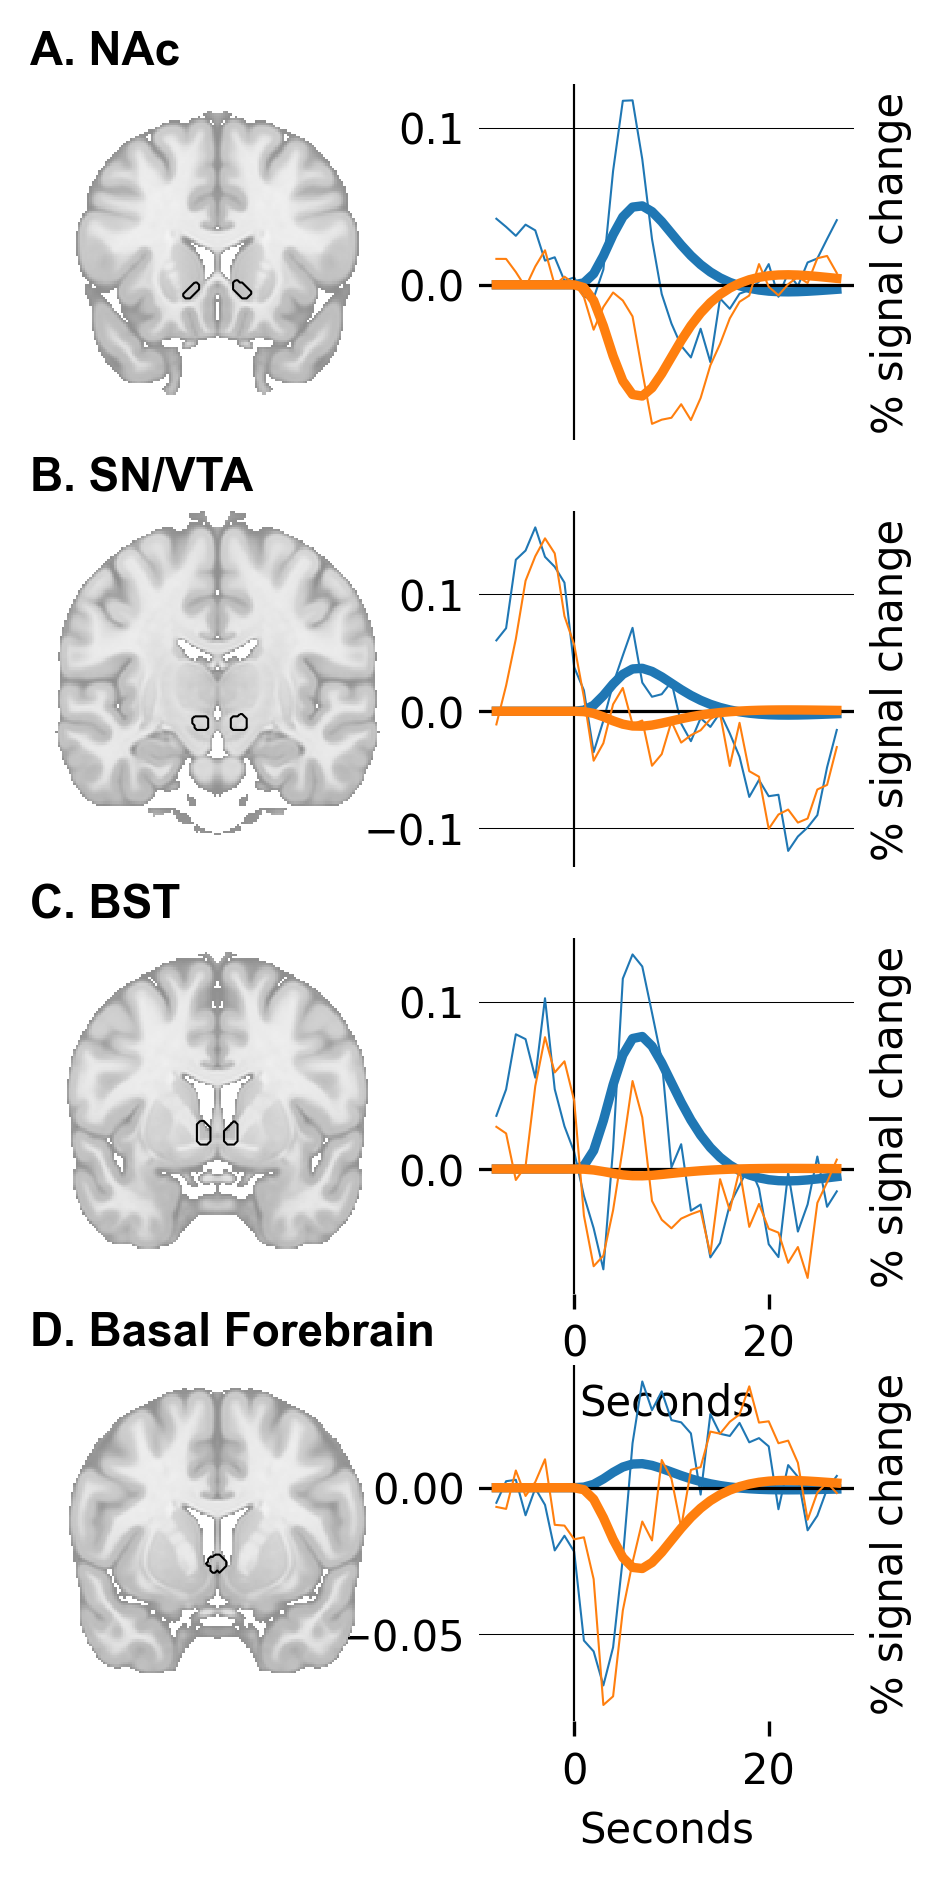

In [3]:
median_gain = np.median( behavior_df['gain'] )
median_diff_invest = np.median( behavior_df['diff_invest'] )
selector = behavior_df['diff_invest'] > median_diff_invest # good learners

nobrain = False

con_names_list = ['Introduction', 'Investment', 'Waiting', 'Outcome']


cols = 2



NAc_mask = 'mask_NAc_MNI.nii.gz'
SN_mask = nli.math_img( 'img > 0.0', img='mask_SN_truamy20_MNI.nii.gz' )
BNST_mask = 'mask_BNST_MNI.nii.gz'
Septal_mask = 'mask_septal_MNI.nii.gz'

cut_vois   = ['NAc', 'SN', 'BNST', 'Septal' ] 
VOIs = cut_vois
cut_titles = ['A. NAc', 'B. SN/VTA', 'C. BST', 'D. Basal Forebrain' ]
cut_mask   = [ NAc_mask, SN_mask, BNST_mask, Septal_mask ]
twin = np.arange(-8, 28)
rows = len(cut_titles)

fig, axes = plt.subplots(rows, cols, figsize=(fig_size_single, rows*fig_size_single/2), dpi=dpi)


for i,cut in enumerate([18, -14, 4, 8]):       
    
    
    ax = axes[i, 0]
    ax.set(frame_on=False)
    ax.set_title(f'{cut_titles[i]}', loc='left', fontdict=opt_subtitle, pad=5.0) #opt_subtitle, 
    
    
    if not nobrain:
        subfig = plotting.plot_stat_map('mni_icbm152_t1_tal_nlin_sym_09a_skullstripped.nii', bg_img=nli.math_img( 'img * (img>35)', img='mni_icbm152_t1_tal_nlin_sym_09a_skullstripped.nii' ), display_mode='y', figure=fig, axes=ax, 
                                        black_bg=False, annotate=False, colorbar=False, cut_coords = [cut], threshold=10000 )
        subfig.add_contours(cut_mask[i], levels=[.0], colors='#000000', linewidths=0.5)

    mean_plots = []
    
    VOI = cut_vois[i]
    
    df = pd.read_csv(f'{voi_csv}_{VOI}.csv')
    
    condition = 'outcome_start'
    trials = [3,20]
    for player in [1,2]:
        sel = ( df['condition']=='%s_%d' % (condition, player) ) & ( df['trial'].isin(range(trials[0],trials[1])) )
        bs = df[sel][ 'b'].values
        y = df[sel][[ 'y_t%+d' % t for t in twin ]].values
        y_mean = np.mean( y, axis=0 )
        y_err = np.std( y, axis=0 ) / np.sqrt(y.shape[0])
        n_subjects = y.shape[1]

        X_mean = np.mean( df[sel][[ 'X_t%+d' % t for t in twin ]].values, axis=0 ) 
        if abs(np.max(X_mean)) < 0.1:
            X_mean = X_mean/np.max(X_mean)
        X_mean = X_mean * np.mean( bs )
        X_err = np.nanstd( bs ) / np.sqrt(y.shape[0])
  
        ax = axes[i,1]
        ax.set(frame_on=False)
        if i >= 2:
            ax.set(xlabel='Seconds')
        else:
            ax.xaxis.set_ticklabels([])
            ax.set_xticks([])

        ax.set(ylabel='% signal change' ) 
        ax.yaxis.set_label_position("right")
        
        ax.axhline(y=0, linewidth=0.75, color='k')
        ax.axvline(x=0, linewidth=0.5, color='k')  
        
        ax.yaxis.grid(color='k', ls = '-', lw = 0.25)
        ax.tick_params('y', length=0, width=0)
        
        
        if player==1:
            style_model = {'color':col_player1}
            style_data = {'fillstyle': 'none', 'color':col_player1}                  

        else:
            style_model = {'color':col_player2}
            style_data = {'fillstyle': 'none', 'color':col_player2}

        
        hndl, = ax.plot(twin, X_mean, linewidth=2.25, alpha=1, **style_model, label=['trustworthy','untrustworthy'][player-1])
        mean_plots.append(hndl)
        ax.plot( twin, y_mean, linewidth=0.5, markevery=1, alpha=1, **style_data )

    if i==rows:
        ax.legend( handles=mean_plots[0:2], frameon=True )  
        

fig_output_file = 'figure-4'
print(fig_output_file)
fig.savefig(f'{fig_output_file}.png', bbox_inches='tight', pad_inches=0.25, facecolor='w', edgecolor='w') 
fig.savefig(f'{fig_output_file}.pdf', bbox_inches='tight', pad_inches=0.25, facecolor='w', edgecolor='w')

In [4]:
for i, voi in enumerate(cut_vois):
    bs = brain_df[ (brain_df['condition'] == 'outcome_start_1') & (brain_df['voi'] == voi) ]['b_mean'].values - \
    brain_df[ (brain_df['condition'] == 'outcome_start_2') & (brain_df['voi'] == voi) ]['b_mean'].values
    statres = stats.ttest_1samp(bs, popmean=0.0)
    thresh = 0.05
    d = np.abs( np.mean(bs)/np.std(bs) )
    ci = np.abs( 1.96 *  np.std(bs) / np.sqrt(len(bs)) )
    caption = "%s %18s %16s:    %+0.2f±%0.2f, t%d=%0.1f, p=%.4f, d=%0.1f" % (('* ' if statres.pvalue<thresh else '  '), cut_titles[i], condition, np.mean(bs), ci, len(bs)-1, np.abs(statres.statistic), statres.pvalue, d ) 
    print(caption)

*              A. NAc    outcome_start:    +0.11±0.03, t61=6.3, p=0.0000, d=0.8
*           B. SN/VTA    outcome_start:    +0.05±0.03, t61=3.7, p=0.0005, d=0.5
*              C. BST    outcome_start:    +0.08±0.04, t61=4.0, p=0.0002, d=0.5
*  D. Basal Forebrain    outcome_start:    +0.03±0.03, t61=2.1, p=0.0361, d=0.3
